# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [44]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

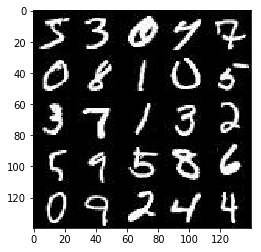

In [45]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

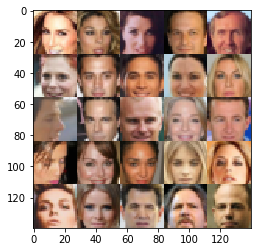

In [46]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [48]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='z_dim')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [61]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x1 = tf.nn.relu(x1)
        #print('discriminator x1:', x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.01 * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.8)
        #x2 = tf.nn.relu(x2)
        #print('discriminator x2:', x2)
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.01 * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.8)
        #x3 = tf.nn.relu(x3)
        #print('discriminator x3:', x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        #print('discriminator flat:', flat)
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [72]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #x = tf.nn.dropout(x, keep_prob=0.8)

        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        #conv1 = tf.nn.dropout(conv1, keep_prob=0.8)

        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #conv2 = tf.nn.dropout(conv2, keep_prob=0.8)

        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding="same")
    return 0.5 * tf.tanh(logits)    
  


'''    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1,(-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01 * x1, x1)
        #x1 = tf.nn.relu(x1)
        #print('generator x1:', x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=3, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(0.01 * x2, x2)
        #x2 = tf.nn.relu(x2)
        #print('generator x2:', x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        x3 = tf.maximum(0.01 * x3, x3)
        #x3 = tf.nn.relu(x3)
        #print('generator x3:', x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #print('generator logits:', logits)

        out = 0.5*tf.tanh(logits)

        return out
'''

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    #ops_t = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    with tf.control_dependencies(ops):        

        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    sampless = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(sampless, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [54]:
from os.path import isdir
if not isdir('checkpoints'):
    !mkdir checkpoints

In [73]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    from time import time
    

    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
        
    #samples, losses = [], []
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            t0=time()
            for batch_images in get_batches(batch_size):
                # TODO: Train Model               
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate:learningRate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate:learningRate})

                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...{}".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    #samples.append(samples)
            print('The residual time nearly to be:  {:.0f}  minutes.'.format((epoch_count-epoch_i-1)*(time()-t0)/60))
                    
                #saver.save(sess, './checkpoints/generator.ckpt')
        saver.save(sess, './checkpoints/generator.ckpt')
        
    #import pickle as pkl
    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    #return losses, samples  

    return 
        

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2...50 Discriminator Loss: 1.3979... Generator Loss: 1.4220
Epoch 1/2...100 Discriminator Loss: 1.5550... Generator Loss: 0.6796
Epoch 1/2...150 Discriminator Loss: 1.1469... Generator Loss: 1.2867
Epoch 1/2...200 Discriminator Loss: 1.2136... Generator Loss: 0.8666
Epoch 1/2...250 Discriminator Loss: 1.1375... Generator Loss: 1.3983
Epoch 1/2...300 Discriminator Loss: 1.0948... Generator Loss: 1.1705
Epoch 1/2...350 Discriminator Loss: 1.1699... Generator Loss: 0.8263
Epoch 1/2...400 Discriminator Loss: 1.2060... Generator Loss: 0.9120
Epoch 1/2...450 Discriminator Loss: 0.9890... Generator Loss: 1.0357
Epoch 1/2...500 Discriminator Loss: 1.2359... Generator Loss: 0.7109


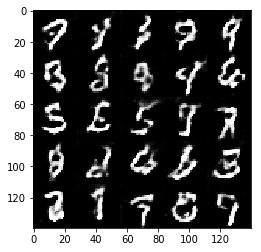

Epoch 1/2...550 Discriminator Loss: 1.3012... Generator Loss: 0.8495
Epoch 1/2...600 Discriminator Loss: 1.3975... Generator Loss: 0.8599
Epoch 1/2...650 Discriminator Loss: 1.1449... Generator Loss: 1.1139
Epoch 1/2...700 Discriminator Loss: 1.0764... Generator Loss: 1.0432
Epoch 1/2...750 Discriminator Loss: 1.0747... Generator Loss: 1.0009
Epoch 1/2...800 Discriminator Loss: 1.4701... Generator Loss: 0.4556
Epoch 1/2...850 Discriminator Loss: 1.3094... Generator Loss: 0.7231
Epoch 1/2...900 Discriminator Loss: 1.0025... Generator Loss: 1.1763
Epoch 1/2...950 Discriminator Loss: 1.1032... Generator Loss: 0.9953
Epoch 1/2...1000 Discriminator Loss: 1.2657... Generator Loss: 0.7289


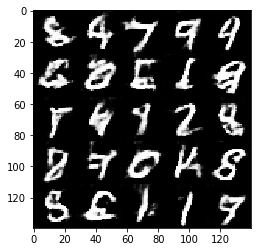

Epoch 1/2...1050 Discriminator Loss: 1.2010... Generator Loss: 0.7962
Epoch 1/2...1100 Discriminator Loss: 1.4077... Generator Loss: 0.7033
Epoch 1/2...1150 Discriminator Loss: 1.1747... Generator Loss: 0.9499
Epoch 1/2...1200 Discriminator Loss: 1.0260... Generator Loss: 1.2706
Epoch 1/2...1250 Discriminator Loss: 1.1017... Generator Loss: 1.1804
Epoch 1/2...1300 Discriminator Loss: 1.0413... Generator Loss: 1.0061
Epoch 1/2...1350 Discriminator Loss: 1.1107... Generator Loss: 0.9996
Epoch 1/2...1400 Discriminator Loss: 1.3990... Generator Loss: 0.6455
Epoch 1/2...1450 Discriminator Loss: 1.0649... Generator Loss: 0.8846
Epoch 1/2...1500 Discriminator Loss: 1.1105... Generator Loss: 1.1120


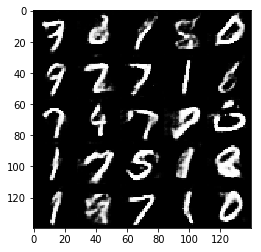

Epoch 1/2...1550 Discriminator Loss: 1.2562... Generator Loss: 0.6458
Epoch 1/2...1600 Discriminator Loss: 1.1830... Generator Loss: 1.2211
Epoch 1/2...1650 Discriminator Loss: 0.9428... Generator Loss: 1.0097
Epoch 1/2...1700 Discriminator Loss: 1.1009... Generator Loss: 0.8626
Epoch 1/2...1750 Discriminator Loss: 1.1364... Generator Loss: 1.0957
Epoch 1/2...1800 Discriminator Loss: 0.9984... Generator Loss: 1.2558
Epoch 1/2...1850 Discriminator Loss: 1.0994... Generator Loss: 1.1378
The residual time nearly to be:  2  minutes.
Epoch 2/2...1900 Discriminator Loss: 1.1778... Generator Loss: 1.3198
Epoch 2/2...1950 Discriminator Loss: 0.9211... Generator Loss: 1.2477
Epoch 2/2...2000 Discriminator Loss: 1.0903... Generator Loss: 0.9580


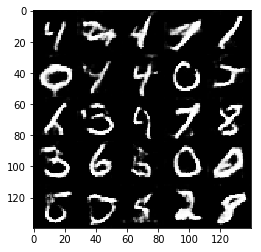

Epoch 2/2...2050 Discriminator Loss: 1.0614... Generator Loss: 1.2034
Epoch 2/2...2100 Discriminator Loss: 1.1527... Generator Loss: 1.0500
Epoch 2/2...2150 Discriminator Loss: 1.3405... Generator Loss: 0.8222
Epoch 2/2...2200 Discriminator Loss: 1.2112... Generator Loss: 1.3356
Epoch 2/2...2250 Discriminator Loss: 1.1857... Generator Loss: 1.3348
Epoch 2/2...2300 Discriminator Loss: 1.0935... Generator Loss: 1.1083
Epoch 2/2...2350 Discriminator Loss: 0.9289... Generator Loss: 1.4827
Epoch 2/2...2400 Discriminator Loss: 1.3192... Generator Loss: 0.7779
Epoch 2/2...2450 Discriminator Loss: 1.2158... Generator Loss: 1.2115
Epoch 2/2...2500 Discriminator Loss: 1.0576... Generator Loss: 1.1301


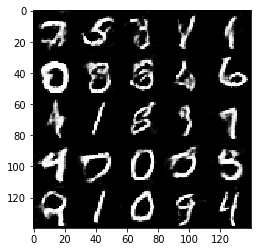

Epoch 2/2...2550 Discriminator Loss: 1.3778... Generator Loss: 0.7172
Epoch 2/2...2600 Discriminator Loss: 1.0831... Generator Loss: 1.1057
Epoch 2/2...2650 Discriminator Loss: 1.0990... Generator Loss: 1.2307
Epoch 2/2...2700 Discriminator Loss: 1.3660... Generator Loss: 0.8590
Epoch 2/2...2750 Discriminator Loss: 1.1017... Generator Loss: 0.9048
Epoch 2/2...2800 Discriminator Loss: 1.2114... Generator Loss: 1.0127
Epoch 2/2...2850 Discriminator Loss: 1.1516... Generator Loss: 0.9413
Epoch 2/2...2900 Discriminator Loss: 1.0765... Generator Loss: 1.1780
Epoch 2/2...2950 Discriminator Loss: 1.0119... Generator Loss: 1.2571
Epoch 2/2...3000 Discriminator Loss: 1.0588... Generator Loss: 1.0247


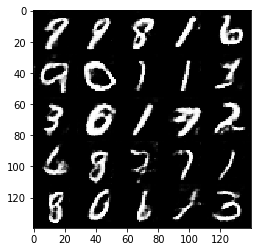

Epoch 2/2...3050 Discriminator Loss: 1.0020... Generator Loss: 1.1221
Epoch 2/2...3100 Discriminator Loss: 1.1208... Generator Loss: 1.0423
Epoch 2/2...3150 Discriminator Loss: 1.1915... Generator Loss: 0.9012
Epoch 2/2...3200 Discriminator Loss: 1.0976... Generator Loss: 1.5828
Epoch 2/2...3250 Discriminator Loss: 1.1554... Generator Loss: 1.0779
Epoch 2/2...3300 Discriminator Loss: 1.0836... Generator Loss: 0.7999
Epoch 2/2...3350 Discriminator Loss: 1.1371... Generator Loss: 1.4338
Epoch 2/2...3400 Discriminator Loss: 1.4287... Generator Loss: 0.5618
Epoch 2/2...3450 Discriminator Loss: 1.3193... Generator Loss: 0.9805
Epoch 2/2...3500 Discriminator Loss: 1.1806... Generator Loss: 1.3106


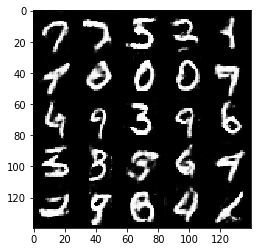

Epoch 2/2...3550 Discriminator Loss: 1.2562... Generator Loss: 1.1089
Epoch 2/2...3600 Discriminator Loss: 1.2264... Generator Loss: 1.2825
Epoch 2/2...3650 Discriminator Loss: 1.0815... Generator Loss: 1.3541
Epoch 2/2...3700 Discriminator Loss: 1.2136... Generator Loss: 1.2400
Epoch 2/2...3750 Discriminator Loss: 1.1273... Generator Loss: 0.9078
The residual time nearly to be:  0  minutes.


In [74]:
batch_size = 32
z_dim = 100
learningRate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learningRate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1...50 Discriminator Loss: 1.1534... Generator Loss: 1.7058
Epoch 1/1...100 Discriminator Loss: 2.4746... Generator Loss: 0.2340
Epoch 1/1...150 Discriminator Loss: 1.5121... Generator Loss: 0.4956
Epoch 1/1...200 Discriminator Loss: 1.4623... Generator Loss: 0.9209
Epoch 1/1...250 Discriminator Loss: 1.3926... Generator Loss: 1.2713
Epoch 1/1...300 Discriminator Loss: 1.1750... Generator Loss: 1.1116
Epoch 1/1...350 Discriminator Loss: 1.2136... Generator Loss: 0.5838
Epoch 1/1...400 Discriminator Loss: 1.2290... Generator Loss: 0.8712
Epoch 1/1...450 Discriminator Loss: 1.1471... Generator Loss: 1.2468
Epoch 1/1...500 Discriminator Loss: 1.5283... Generator Loss: 0.4100


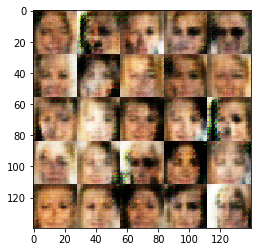

Epoch 1/1...550 Discriminator Loss: 1.3379... Generator Loss: 0.4927
Epoch 1/1...600 Discriminator Loss: 1.3708... Generator Loss: 0.5331
Epoch 1/1...650 Discriminator Loss: 1.2723... Generator Loss: 0.6098
Epoch 1/1...700 Discriminator Loss: 1.1120... Generator Loss: 0.9926
Epoch 1/1...750 Discriminator Loss: 1.1189... Generator Loss: 1.0670
Epoch 1/1...800 Discriminator Loss: 0.7119... Generator Loss: 1.4910
Epoch 1/1...850 Discriminator Loss: 0.7646... Generator Loss: 2.2297
Epoch 1/1...900 Discriminator Loss: 1.2444... Generator Loss: 2.4761
Epoch 1/1...950 Discriminator Loss: 0.7807... Generator Loss: 2.3887
Epoch 1/1...1000 Discriminator Loss: 0.9744... Generator Loss: 0.9549


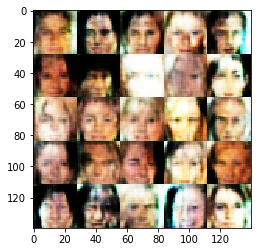

Epoch 1/1...1050 Discriminator Loss: 0.8693... Generator Loss: 1.5336
Epoch 1/1...1100 Discriminator Loss: 0.4545... Generator Loss: 3.0504
Epoch 1/1...1150 Discriminator Loss: 0.6984... Generator Loss: 2.1693
Epoch 1/1...1200 Discriminator Loss: 0.7875... Generator Loss: 1.9677
Epoch 1/1...1250 Discriminator Loss: 0.4266... Generator Loss: 2.7719
Epoch 1/1...1300 Discriminator Loss: 1.3046... Generator Loss: 2.6218
Epoch 1/1...1350 Discriminator Loss: 1.5319... Generator Loss: 3.8376
Epoch 1/1...1400 Discriminator Loss: 0.4997... Generator Loss: 2.5867
Epoch 1/1...1450 Discriminator Loss: 0.4258... Generator Loss: 3.2734
Epoch 1/1...1500 Discriminator Loss: 0.7823... Generator Loss: 2.5566


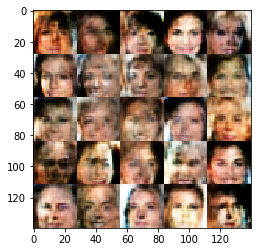

Epoch 1/1...1550 Discriminator Loss: 0.4966... Generator Loss: 1.9825
Epoch 1/1...1600 Discriminator Loss: 1.5330... Generator Loss: 0.5415
Epoch 1/1...1650 Discriminator Loss: 0.4913... Generator Loss: 4.0917
Epoch 1/1...1700 Discriminator Loss: 0.5781... Generator Loss: 3.5125
Epoch 1/1...1750 Discriminator Loss: 0.3744... Generator Loss: 4.1892
Epoch 1/1...1800 Discriminator Loss: 0.7130... Generator Loss: 2.8067
Epoch 1/1...1850 Discriminator Loss: 0.4469... Generator Loss: 3.2725
Epoch 1/1...1900 Discriminator Loss: 1.3582... Generator Loss: 1.9697
Epoch 1/1...1950 Discriminator Loss: 1.0125... Generator Loss: 2.6605
Epoch 1/1...2000 Discriminator Loss: 0.4927... Generator Loss: 5.4719


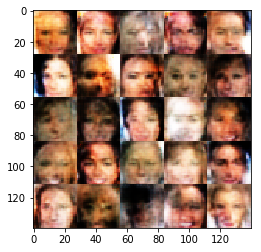

Epoch 1/1...2050 Discriminator Loss: 1.4454... Generator Loss: 0.5357
Epoch 1/1...2100 Discriminator Loss: 1.4603... Generator Loss: 2.9100
Epoch 1/1...2150 Discriminator Loss: 0.6342... Generator Loss: 2.7184
Epoch 1/1...2200 Discriminator Loss: 0.5171... Generator Loss: 3.2715
Epoch 1/1...2250 Discriminator Loss: 0.5797... Generator Loss: 2.2387
Epoch 1/1...2300 Discriminator Loss: 0.5744... Generator Loss: 3.3733
Epoch 1/1...2350 Discriminator Loss: 0.5444... Generator Loss: 2.7875
Epoch 1/1...2400 Discriminator Loss: 0.8034... Generator Loss: 1.3327
Epoch 1/1...2450 Discriminator Loss: 2.1045... Generator Loss: 0.3585
Epoch 1/1...2500 Discriminator Loss: 1.0360... Generator Loss: 2.6346


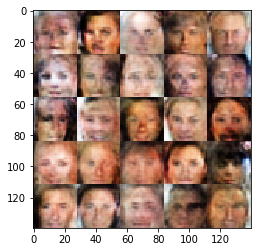

Epoch 1/1...2550 Discriminator Loss: 0.6904... Generator Loss: 1.7606
Epoch 1/1...2600 Discriminator Loss: 1.7341... Generator Loss: 0.5731
Epoch 1/1...2650 Discriminator Loss: 0.5821... Generator Loss: 2.1853
Epoch 1/1...2700 Discriminator Loss: 0.9684... Generator Loss: 1.1298
Epoch 1/1...2750 Discriminator Loss: 0.5406... Generator Loss: 2.1409
Epoch 1/1...2800 Discriminator Loss: 0.6213... Generator Loss: 2.3286
Epoch 1/1...2850 Discriminator Loss: 0.6609... Generator Loss: 4.2885
Epoch 1/1...2900 Discriminator Loss: 0.5268... Generator Loss: 2.2555
Epoch 1/1...2950 Discriminator Loss: 1.0929... Generator Loss: 0.7739
Epoch 1/1...3000 Discriminator Loss: 0.6355... Generator Loss: 1.7496


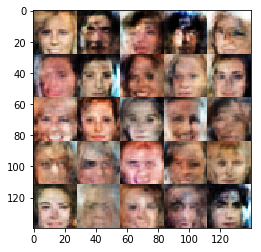

Epoch 1/1...3050 Discriminator Loss: 0.4503... Generator Loss: 2.7746
Epoch 1/1...3100 Discriminator Loss: 0.4401... Generator Loss: 3.1485
Epoch 1/1...3150 Discriminator Loss: 0.5534... Generator Loss: 2.6165
Epoch 1/1...3200 Discriminator Loss: 1.2337... Generator Loss: 0.8269
Epoch 1/1...3250 Discriminator Loss: 0.6418... Generator Loss: 2.3085
Epoch 1/1...3300 Discriminator Loss: 0.4723... Generator Loss: 3.4108
Epoch 1/1...3350 Discriminator Loss: 0.7112... Generator Loss: 1.6994
Epoch 1/1...3400 Discriminator Loss: 0.5361... Generator Loss: 2.9327
Epoch 1/1...3450 Discriminator Loss: 0.6168... Generator Loss: 1.9542
Epoch 1/1...3500 Discriminator Loss: 0.4544... Generator Loss: 3.9674


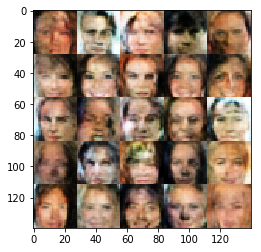

Epoch 1/1...3550 Discriminator Loss: 0.4184... Generator Loss: 3.9428
Epoch 1/1...3600 Discriminator Loss: 0.4621... Generator Loss: 2.9940
Epoch 1/1...3650 Discriminator Loss: 0.4898... Generator Loss: 2.4080
Epoch 1/1...3700 Discriminator Loss: 0.3718... Generator Loss: 4.5742
Epoch 1/1...3750 Discriminator Loss: 0.4503... Generator Loss: 4.7496
Epoch 1/1...3800 Discriminator Loss: 0.8869... Generator Loss: 1.4481
Epoch 1/1...3850 Discriminator Loss: 0.7274... Generator Loss: 2.0633
Epoch 1/1...3900 Discriminator Loss: 0.5128... Generator Loss: 2.6213
Epoch 1/1...3950 Discriminator Loss: 0.4940... Generator Loss: 2.7718
Epoch 1/1...4000 Discriminator Loss: 0.4523... Generator Loss: 3.1894


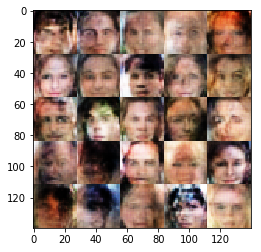

Epoch 1/1...4050 Discriminator Loss: 1.1390... Generator Loss: 0.8079
Epoch 1/1...4100 Discriminator Loss: 0.4084... Generator Loss: 4.3105
Epoch 1/1...4150 Discriminator Loss: 0.9956... Generator Loss: 1.6932
Epoch 1/1...4200 Discriminator Loss: 0.6346... Generator Loss: 4.3712
Epoch 1/1...4250 Discriminator Loss: 0.5600... Generator Loss: 5.0783
Epoch 1/1...4300 Discriminator Loss: 0.6240... Generator Loss: 1.7213
Epoch 1/1...4350 Discriminator Loss: 0.4033... Generator Loss: 4.5313
Epoch 1/1...4400 Discriminator Loss: 0.4085... Generator Loss: 3.4087
Epoch 1/1...4450 Discriminator Loss: 0.7275... Generator Loss: 1.6753
Epoch 1/1...4500 Discriminator Loss: 0.7178... Generator Loss: 1.6100


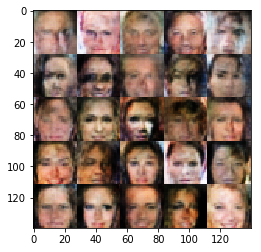

Epoch 1/1...4550 Discriminator Loss: 0.6944... Generator Loss: 3.1632
Epoch 1/1...4600 Discriminator Loss: 0.4174... Generator Loss: 4.7802
Epoch 1/1...4650 Discriminator Loss: 0.3925... Generator Loss: 4.7841
Epoch 1/1...4700 Discriminator Loss: 0.4985... Generator Loss: 2.7326
Epoch 1/1...4750 Discriminator Loss: 0.5463... Generator Loss: 4.5776
Epoch 1/1...4800 Discriminator Loss: 0.5209... Generator Loss: 3.6235
Epoch 1/1...4850 Discriminator Loss: 0.4872... Generator Loss: 3.0373
Epoch 1/1...4900 Discriminator Loss: 0.8509... Generator Loss: 1.1218
Epoch 1/1...4950 Discriminator Loss: 0.6636... Generator Loss: 1.9411
Epoch 1/1...5000 Discriminator Loss: 0.5140... Generator Loss: 2.9748


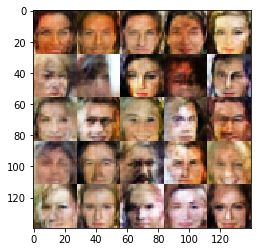

Epoch 1/1...5050 Discriminator Loss: 0.4744... Generator Loss: 3.6603
Epoch 1/1...5100 Discriminator Loss: 0.5684... Generator Loss: 2.3996
Epoch 1/1...5150 Discriminator Loss: 0.5431... Generator Loss: 4.0895
Epoch 1/1...5200 Discriminator Loss: 0.5905... Generator Loss: 1.9575
Epoch 1/1...5250 Discriminator Loss: 0.6382... Generator Loss: 1.9063
Epoch 1/1...5300 Discriminator Loss: 0.7136... Generator Loss: 1.7813
Epoch 1/1...5350 Discriminator Loss: 0.3902... Generator Loss: 3.5019
Epoch 1/1...5400 Discriminator Loss: 0.4278... Generator Loss: 3.7767
Epoch 1/1...5450 Discriminator Loss: 0.8171... Generator Loss: 1.7563
Epoch 1/1...5500 Discriminator Loss: 0.5793... Generator Loss: 2.0833


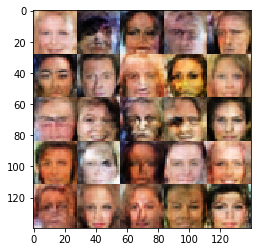

Epoch 1/1...5550 Discriminator Loss: 0.3777... Generator Loss: 5.2692
Epoch 1/1...5600 Discriminator Loss: 0.8043... Generator Loss: 2.6526
Epoch 1/1...5650 Discriminator Loss: 2.4246... Generator Loss: 4.2619
Epoch 1/1...5700 Discriminator Loss: 0.5443... Generator Loss: 2.1832
Epoch 1/1...5750 Discriminator Loss: 0.9811... Generator Loss: 3.8842
Epoch 1/1...5800 Discriminator Loss: 0.4015... Generator Loss: 3.9542
Epoch 1/1...5850 Discriminator Loss: 0.4080... Generator Loss: 3.9286
Epoch 1/1...5900 Discriminator Loss: 0.7263... Generator Loss: 1.6005
Epoch 1/1...5950 Discriminator Loss: 0.7746... Generator Loss: 1.6847
Epoch 1/1...6000 Discriminator Loss: 0.7606... Generator Loss: 2.7479


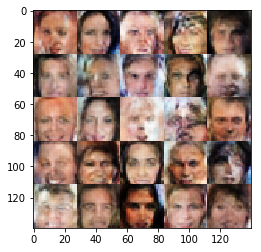

Epoch 1/1...6050 Discriminator Loss: 0.4243... Generator Loss: 3.9568
Epoch 1/1...6100 Discriminator Loss: 0.4449... Generator Loss: 3.8323
Epoch 1/1...6150 Discriminator Loss: 0.3898... Generator Loss: 4.6739
Epoch 1/1...6200 Discriminator Loss: 0.6515... Generator Loss: 2.0966
Epoch 1/1...6250 Discriminator Loss: 1.3195... Generator Loss: 0.6280
Epoch 1/1...6300 Discriminator Loss: 0.8367... Generator Loss: 1.9345
Epoch 1/1...6350 Discriminator Loss: 0.7335... Generator Loss: 1.3473
Epoch 1/1...6400 Discriminator Loss: 0.4718... Generator Loss: 3.0979
Epoch 1/1...6450 Discriminator Loss: 0.5238... Generator Loss: 3.2094
Epoch 1/1...6500 Discriminator Loss: 0.3881... Generator Loss: 4.6171


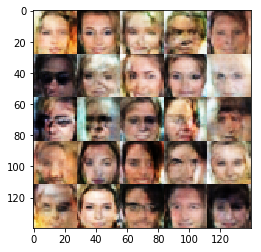

Epoch 1/1...6550 Discriminator Loss: 0.4633... Generator Loss: 3.3936
Epoch 1/1...6600 Discriminator Loss: 0.5316... Generator Loss: 1.6757
Epoch 1/1...6650 Discriminator Loss: 0.9339... Generator Loss: 2.2415
Epoch 1/1...6700 Discriminator Loss: 0.7285... Generator Loss: 2.4146
Epoch 1/1...6750 Discriminator Loss: 0.4118... Generator Loss: 3.7271
Epoch 1/1...6800 Discriminator Loss: 0.4773... Generator Loss: 3.8009
Epoch 1/1...6850 Discriminator Loss: 0.7690... Generator Loss: 1.5436
Epoch 1/1...6900 Discriminator Loss: 0.7018... Generator Loss: 2.0884
Epoch 1/1...6950 Discriminator Loss: 0.7249... Generator Loss: 1.2335
Epoch 1/1...7000 Discriminator Loss: 0.9204... Generator Loss: 1.7632


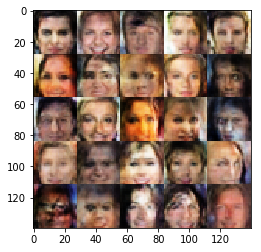

Epoch 1/1...7050 Discriminator Loss: 0.3978... Generator Loss: 4.8166
Epoch 1/1...7100 Discriminator Loss: 1.3199... Generator Loss: 3.0411
Epoch 1/1...7150 Discriminator Loss: 0.4779... Generator Loss: 2.8702
Epoch 1/1...7200 Discriminator Loss: 0.4251... Generator Loss: 5.7815
Epoch 1/1...7250 Discriminator Loss: 0.5850... Generator Loss: 5.8125
Epoch 1/1...7300 Discriminator Loss: 0.4107... Generator Loss: 5.4850
Epoch 1/1...7350 Discriminator Loss: 0.6099... Generator Loss: 2.1794
Epoch 1/1...7400 Discriminator Loss: 0.5988... Generator Loss: 2.1283
Epoch 1/1...7450 Discriminator Loss: 0.6349... Generator Loss: 1.6023
Epoch 1/1...7500 Discriminator Loss: 0.4696... Generator Loss: 4.1173


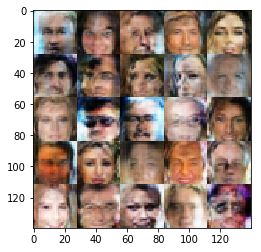

Epoch 1/1...7550 Discriminator Loss: 0.5112... Generator Loss: 2.2729
Epoch 1/1...7600 Discriminator Loss: 0.4713... Generator Loss: 3.0616
Epoch 1/1...7650 Discriminator Loss: 0.4805... Generator Loss: 3.0296
Epoch 1/1...7700 Discriminator Loss: 0.6296... Generator Loss: 2.8461
Epoch 1/1...7750 Discriminator Loss: 0.7454... Generator Loss: 1.4846
Epoch 1/1...7800 Discriminator Loss: 0.4048... Generator Loss: 4.1476
Epoch 1/1...7850 Discriminator Loss: 0.5655... Generator Loss: 2.4235
Epoch 1/1...7900 Discriminator Loss: 0.5009... Generator Loss: 4.5676
Epoch 1/1...7950 Discriminator Loss: 1.5208... Generator Loss: 0.6299
Epoch 1/1...8000 Discriminator Loss: 0.6588... Generator Loss: 2.1898


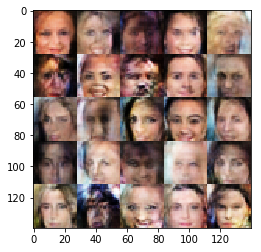

Epoch 1/1...8050 Discriminator Loss: 0.4616... Generator Loss: 4.0368
Epoch 1/1...8100 Discriminator Loss: 0.5621... Generator Loss: 1.7602
Epoch 1/1...8150 Discriminator Loss: 0.4798... Generator Loss: 3.5350
Epoch 1/1...8200 Discriminator Loss: 1.1185... Generator Loss: 1.0646
Epoch 1/1...8250 Discriminator Loss: 0.4907... Generator Loss: 3.6894
Epoch 1/1...8300 Discriminator Loss: 0.5289... Generator Loss: 2.5740
Epoch 1/1...8350 Discriminator Loss: 0.4195... Generator Loss: 4.0578
Epoch 1/1...8400 Discriminator Loss: 0.4471... Generator Loss: 4.0295
Epoch 1/1...8450 Discriminator Loss: 0.5929... Generator Loss: 2.2538
Epoch 1/1...8500 Discriminator Loss: 0.5210... Generator Loss: 3.0206


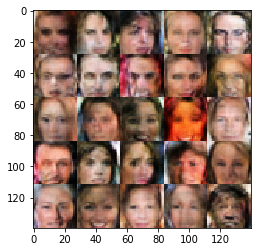

Epoch 1/1...8550 Discriminator Loss: 0.4417... Generator Loss: 3.0437
Epoch 1/1...8600 Discriminator Loss: 0.9263... Generator Loss: 1.3270
Epoch 1/1...8650 Discriminator Loss: 0.3783... Generator Loss: 4.7382
Epoch 1/1...8700 Discriminator Loss: 0.6284... Generator Loss: 2.4163
Epoch 1/1...8750 Discriminator Loss: 1.0443... Generator Loss: 2.7337
Epoch 1/1...8800 Discriminator Loss: 0.5056... Generator Loss: 2.6070
Epoch 1/1...8850 Discriminator Loss: 0.4734... Generator Loss: 4.0610
Epoch 1/1...8900 Discriminator Loss: 0.5857... Generator Loss: 2.7710
Epoch 1/1...8950 Discriminator Loss: 0.4098... Generator Loss: 3.4403
Epoch 1/1...9000 Discriminator Loss: 0.4363... Generator Loss: 3.6800


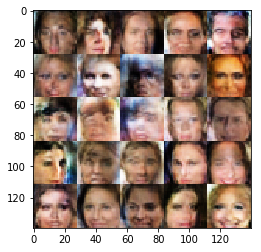

Epoch 1/1...9050 Discriminator Loss: 0.4497... Generator Loss: 4.4878
Epoch 1/1...9100 Discriminator Loss: 0.6823... Generator Loss: 1.9356
Epoch 1/1...9150 Discriminator Loss: 0.7020... Generator Loss: 2.9741
Epoch 1/1...9200 Discriminator Loss: 0.4081... Generator Loss: 3.7344
Epoch 1/1...9250 Discriminator Loss: 0.7227... Generator Loss: 2.0274
Epoch 1/1...9300 Discriminator Loss: 0.4549... Generator Loss: 3.9043
Epoch 1/1...9350 Discriminator Loss: 0.7304... Generator Loss: 2.1135
Epoch 1/1...9400 Discriminator Loss: 0.9761... Generator Loss: 1.9978
Epoch 1/1...9450 Discriminator Loss: 0.9710... Generator Loss: 1.7508
Epoch 1/1...9500 Discriminator Loss: 0.5039... Generator Loss: 3.7665


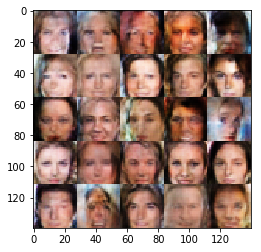

Epoch 1/1...9550 Discriminator Loss: 0.4623... Generator Loss: 3.8846
Epoch 1/1...9600 Discriminator Loss: 0.4139... Generator Loss: 4.1174
Epoch 1/1...9650 Discriminator Loss: 0.5517... Generator Loss: 5.2062
Epoch 1/1...9700 Discriminator Loss: 0.4444... Generator Loss: 3.3165
Epoch 1/1...9750 Discriminator Loss: 0.7357... Generator Loss: 2.8224
Epoch 1/1...9800 Discriminator Loss: 0.7407... Generator Loss: 3.2278
Epoch 1/1...9850 Discriminator Loss: 0.5398... Generator Loss: 3.4360
Epoch 1/1...9900 Discriminator Loss: 1.0793... Generator Loss: 1.1395
Epoch 1/1...9950 Discriminator Loss: 0.4167... Generator Loss: 4.5287
Epoch 1/1...10000 Discriminator Loss: 0.4664... Generator Loss: 4.3851


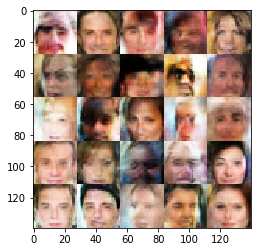

Epoch 1/1...10050 Discriminator Loss: 0.6707... Generator Loss: 1.8181
Epoch 1/1...10100 Discriminator Loss: 0.4800... Generator Loss: 3.0349
Epoch 1/1...10150 Discriminator Loss: 0.8403... Generator Loss: 1.3862
Epoch 1/1...10200 Discriminator Loss: 0.5046... Generator Loss: 2.1077
Epoch 1/1...10250 Discriminator Loss: 0.7969... Generator Loss: 2.2611
Epoch 1/1...10300 Discriminator Loss: 0.7202... Generator Loss: 1.9445
Epoch 1/1...10350 Discriminator Loss: 0.9217... Generator Loss: 2.0209
Epoch 1/1...10400 Discriminator Loss: 0.5864... Generator Loss: 4.6463
Epoch 1/1...10450 Discriminator Loss: 0.4070... Generator Loss: 4.4722
Epoch 1/1...10500 Discriminator Loss: 0.5056... Generator Loss: 2.8853


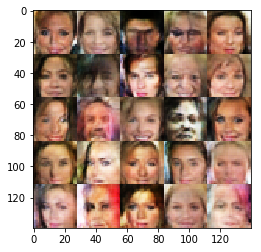

Epoch 1/1...10550 Discriminator Loss: 0.6762... Generator Loss: 2.3499
Epoch 1/1...10600 Discriminator Loss: 0.5050... Generator Loss: 2.9151
Epoch 1/1...10650 Discriminator Loss: 0.5267... Generator Loss: 3.8732
Epoch 1/1...10700 Discriminator Loss: 1.3239... Generator Loss: 0.9256
Epoch 1/1...10750 Discriminator Loss: 0.6897... Generator Loss: 2.6502
Epoch 1/1...10800 Discriminator Loss: 0.5726... Generator Loss: 2.8174
Epoch 1/1...10850 Discriminator Loss: 0.6615... Generator Loss: 1.5055
Epoch 1/1...10900 Discriminator Loss: 0.4853... Generator Loss: 2.8009
Epoch 1/1...10950 Discriminator Loss: 0.5342... Generator Loss: 2.3097
Epoch 1/1...11000 Discriminator Loss: 1.1070... Generator Loss: 1.0030


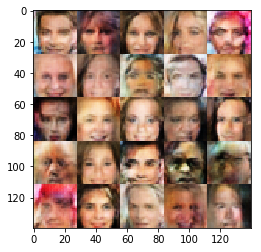

Epoch 1/1...11050 Discriminator Loss: 0.7512... Generator Loss: 2.1974
Epoch 1/1...11100 Discriminator Loss: 0.5312... Generator Loss: 3.5707
Epoch 1/1...11150 Discriminator Loss: 0.5948... Generator Loss: 2.0895
Epoch 1/1...11200 Discriminator Loss: 0.5826... Generator Loss: 2.6626
Epoch 1/1...11250 Discriminator Loss: 0.4204... Generator Loss: 3.0285
Epoch 1/1...11300 Discriminator Loss: 0.5541... Generator Loss: 2.7038
Epoch 1/1...11350 Discriminator Loss: 0.5562... Generator Loss: 1.8174
Epoch 1/1...11400 Discriminator Loss: 0.6239... Generator Loss: 3.2267
Epoch 1/1...11450 Discriminator Loss: 0.8969... Generator Loss: 1.3695
Epoch 1/1...11500 Discriminator Loss: 0.5804... Generator Loss: 2.6638


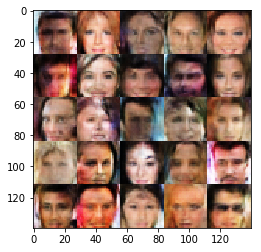

Epoch 1/1...11550 Discriminator Loss: 0.5637... Generator Loss: 2.4174
Epoch 1/1...11600 Discriminator Loss: 0.3967... Generator Loss: 4.3182
Epoch 1/1...11650 Discriminator Loss: 0.6172... Generator Loss: 1.7379
Epoch 1/1...11700 Discriminator Loss: 0.4930... Generator Loss: 2.9195
Epoch 1/1...11750 Discriminator Loss: 0.7889... Generator Loss: 1.5567
Epoch 1/1...11800 Discriminator Loss: 0.5361... Generator Loss: 3.2264
Epoch 1/1...11850 Discriminator Loss: 1.1085... Generator Loss: 1.3438
Epoch 1/1...11900 Discriminator Loss: 0.7572... Generator Loss: 2.0607
Epoch 1/1...11950 Discriminator Loss: 0.6001... Generator Loss: 1.7548
Epoch 1/1...12000 Discriminator Loss: 0.5316... Generator Loss: 2.3388


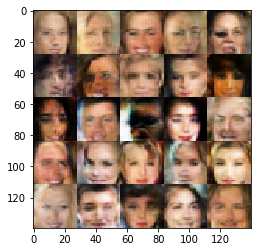

Epoch 1/1...12050 Discriminator Loss: 0.4156... Generator Loss: 4.6181
Epoch 1/1...12100 Discriminator Loss: 0.7036... Generator Loss: 1.4919
Epoch 1/1...12150 Discriminator Loss: 0.7772... Generator Loss: 1.5292
Epoch 1/1...12200 Discriminator Loss: 0.5105... Generator Loss: 3.4249
Epoch 1/1...12250 Discriminator Loss: 0.4361... Generator Loss: 4.7019
Epoch 1/1...12300 Discriminator Loss: 0.6365... Generator Loss: 2.5526
Epoch 1/1...12350 Discriminator Loss: 1.6148... Generator Loss: 0.6809
Epoch 1/1...12400 Discriminator Loss: 0.4626... Generator Loss: 3.6252
Epoch 1/1...12450 Discriminator Loss: 0.7590... Generator Loss: 1.4415
Epoch 1/1...12500 Discriminator Loss: 0.4871... Generator Loss: 2.6707


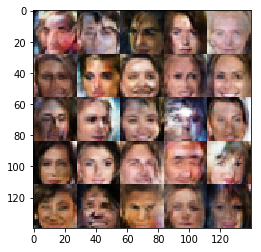

Epoch 1/1...12550 Discriminator Loss: 0.5449... Generator Loss: 3.2361
Epoch 1/1...12600 Discriminator Loss: 0.8658... Generator Loss: 1.5412
Epoch 1/1...12650 Discriminator Loss: 0.8254... Generator Loss: 1.4564
The residual time nearly to be:  0  minutes.


In [75]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。